# Shoot and Go 
## Looking for the right p parameter via Shoot and Go heuristic 

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#initialization
from objfun_node2vec import N2V
n2v = N2V('../data/clear_cluster_test/one_eighth.csv',
            '../data/clear_cluster_test/labels.csv')

The p parameter is generated randomly within an interval $[0.125,4.125)$.

In [4]:
n2v.generate_point()

3.776951110170383

__Generalized Shoot&Go__
 - Shoot & Go heuristic (also known as Iterated Local Search, Random-restart hill climbing, etc)
     - $hmax \in \{ 0, 1, \ldots, \infty \}$ parameter - maximum number of local searches / hill climbs
     - note that $\mathrm{SG}_{0}$ is pure Random Shooting (Random Search)

In [5]:
from heur_sg import ShootAndGo

In [6]:
NUM_RUNS = 30 
maxeval = 30 

__2. Performance evaluation__

In [7]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

__General experiment setup__

Runs selected objective function (of) using selected heuristic multiple times, stores and returns data (results) in a data frame.

In [8]:
def experiment(of, num_runs, hmax, params):
    results = []
    for i in tqdm(range(num_runs), 'Testing hmax = {}'.format(hmax)):
        result = ShootAndGo(of, maxeval=maxeval, hmax=hmax, params=params).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'SG_{}'.format(hmax) # name of the heuristic
        result['hmax'] = hmax
        results.append(result)
    
    # write results to csv file 
    now = datetime.now()
    current_time = now.strftime('%Y%m%d%H%M')
    res = pd.DataFrame(results, columns=['heur', 'run', 'hmax', 'best_x', 'best_y', 'neval'])
    res.to_csv('../results/' + current_time + '_one_eighth_SG_' + str(hmax) + '.csv')
    
    return res

__Objective function extrems__

(It was found out that there are at least 2 extrems of the objective function.

Moreover, the number of extrems depened on the rounding of the p parameter. 

Rounding to 2 gives 3 maxima, and 2 of them dulicates the maxuma found by rounding to 3 and 4 decimals.) 

- Evaluating the objective function at 1000 values of p evenly spaced over an interval $[0.25,4.125]$ shows that there are many extrems.


Let's try not rounded values:

=> so, I will use unrounded values

In [9]:
data = pd.DataFrame(columns=['p','score'])
for i in np.linspace(0.25,4.125,500):
    data = data.append({'p':i,'score':n2v.evaluate(i)}, ignore_index=True)

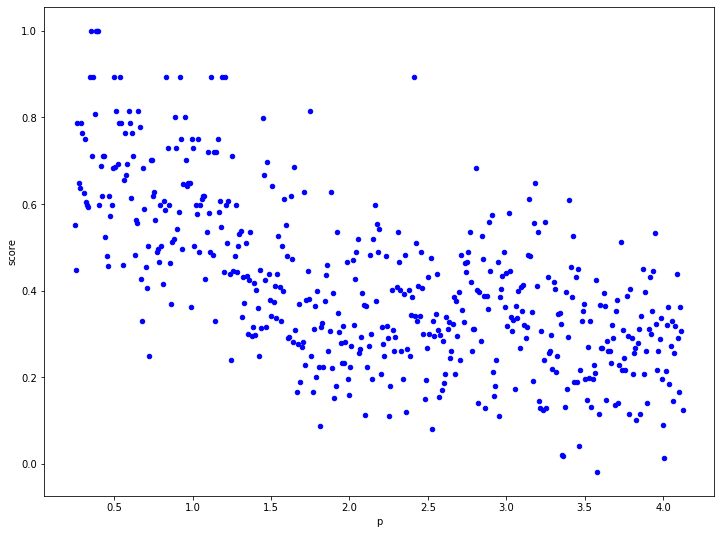

In [10]:
data.plot(figsize=(12, 9),kind='scatter',x='p',y='score', color='blue')
plt.show()

### Node2Vec experiments

the step is 0.125 (=1/8), diameter of the neighborhood d = 0.125*2 

the get_neighborhood() function gives 2 left and 2 right neighoors, if possible 

In [11]:
n2v.get_neighborhood(1.0,0.125*2)

array([0.875, 0.75 , 1.125, 1.25 ])

It turned out that calculation on default parameters does not hit the optimal p parameter value, or probably it need more computational facilities. So, the ability to try another set of parameters was added.

In [12]:
default_params=[1., 10, 80, 10]
opt_params=[2., 10, 100, 5] # known from the previous experiments optimal paremeters 

__Calculations on the defalut parameter values__

In [13]:
def_table = pd.DataFrame()
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]: 
    res = experiment(n2v, maxeval, hmax, default_params)
    def_table = pd.concat([def_table, res], axis=0)

In [14]:
def_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 29
Data columns (total 6 columns):
heur      240 non-null object
run       240 non-null int64
hmax      240 non-null float64
best_x    240 non-null object
best_y    240 non-null float64
neval     240 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 13.1+ KB


In [15]:
def_table.head()

heur  run  hmax                                  best_x    best_y  neval
0  SG_0    0   0.0  [0.36079226162441325, 1.0, 10, 80, 10]  1.000000    7.0
1  SG_0    1   0.0  [0.19128210454387062, 1.0, 10, 80, 10]  0.892857    inf
2  SG_0    2   0.0   [0.3121943545405519, 1.0, 10, 80, 10]  0.892857    inf
3  SG_0    3   0.0   [0.9018234339531448, 1.0, 10, 80, 10]  0.712000    inf
4  SG_0    4   0.0   [0.3737885120833795, 1.0, 10, 80, 10]  0.892857    inf

The quality of solutions based on hmax

In [16]:
def_table.groupby(['hmax'])['best_y'].median()

hmax
0.0     0.892857
1.0     0.813953
2.0     0.892857
5.0     0.813953
10.0    0.735075
20.0    0.892857
50.0    0.805786
inf     0.802810
Name: best_y, dtype: float64

In [17]:
def_table.groupby(['hmax'])['best_y'].mean()

hmax
0.0     0.897870
1.0     0.825004
2.0     0.832075
5.0     0.822604
10.0    0.736151
20.0    0.819590
50.0    0.791126
inf     0.787155
Name: best_y, dtype: float64

As __Box-Whiskers plot__:

In [19]:
# import visualization libraries
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

<IPython.core.display.Javascript object>


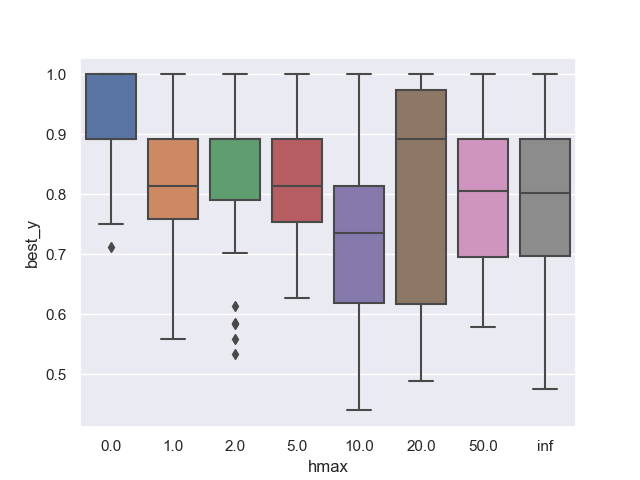

In [26]:
ax = sns.boxplot(x="hmax", y="best_y", data=def_table)

__Optimal parameters usage__

In [ ]:
# opt_table = pd.DataFrame()
# for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]: 
#     res = experiment(n2v, maxeval, hmax, opt_params)
#     opt_table = pd.concat([opt_table, res], axis=0)

In [ ]:
# opt_table.head()

In [ ]:
# opt_table.loc[opt_table['neval']==np.inf]

In [ ]:
# opt_table.groupby(['hmax'])['best_y'].median()

__Number of evaluations (when successful), based on hmax?__

In [21]:
def_table['success'] = def_table['neval'] < np.inf

In [22]:
def_table[def_table['success'] == True].head()

heur  run  hmax                                  best_x  best_y  neval  \
0   SG_0    0   0.0  [0.36079226162441325, 1.0, 10, 80, 10]     1.0    7.0   
8   SG_0    8   0.0   [0.3379099750908874, 1.0, 10, 80, 10]     1.0   13.0   
10  SG_0   10   0.0  [0.22438166924037217, 1.0, 10, 80, 10]     1.0   17.0   
15  SG_0   15   0.0   [0.3924366557693628, 1.0, 10, 80, 10]     1.0   11.0   
16  SG_0   16   0.0  [0.20527281000319553, 1.0, 10, 80, 10]     1.0    8.0   

    success  
0      True  
8      True  
10     True  
15     True  
16     True

In [23]:
def_table[def_table['success'] == True].groupby(['hmax'])['neval'].mean()

hmax
0.0     17.000000
1.0     14.833333
2.0     18.142857
5.0     15.000000
10.0    12.000000
20.0    19.625000
50.0    10.500000
inf     11.714286
Name: neval, dtype: float64

In [24]:
def_table[def_table['success'] == True].groupby(['hmax'])['neval'].median()

hmax
0.0     17.0
1.0     16.0
2.0     25.0
5.0     14.0
10.0     3.0
20.0    20.0
50.0    10.5
inf     10.0
Name: neval, dtype: float64

<IPython.core.display.Javascript object>


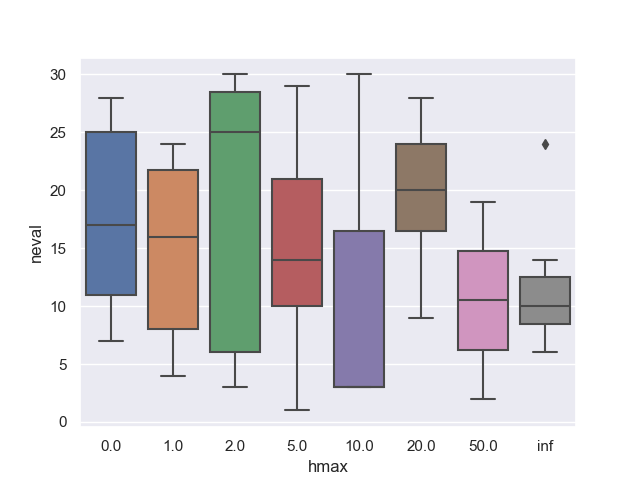

In [27]:
ax = sns.boxplot(x="hmax", y="neval", data=def_table[def_table['success'] == True])

__Reliability__

In [28]:
rel_by_hmax = def_table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: len([n for n in x if n < np.inf])/len(x)
)

In [29]:
rel_by_hmax

neval
hmax          
0.0   0.300000
1.0   0.200000
2.0   0.233333
5.0   0.166667
10.0  0.100000
20.0  0.266667
50.0  0.066667
inf   0.233333

<IPython.core.display.Javascript object>


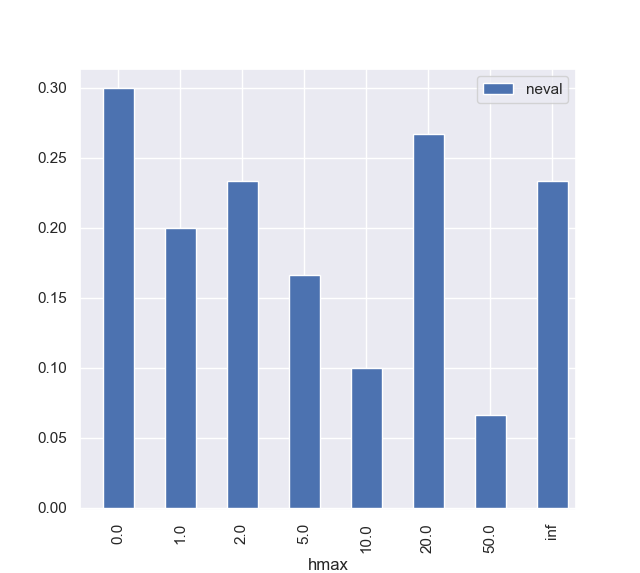

In [31]:
ax = rel_by_hmax.plot(kind='bar')

In [32]:
feo_by_hmax = def_table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: np.mean([n for n in x if n < np.inf])/(len([n for n in x if n < np.inf])/len(x))
    #                 ^^^   mean number of evaluations ^^^ / ^^^             reliability         ^^^^
)

In [33]:
feo_by_hmax

neval
hmax            
0.0    56.666667
1.0    74.166667
2.0    77.755102
5.0    90.000000
10.0  120.000000
20.0   73.593750
50.0  157.500000
inf    50.204082

<IPython.core.display.Javascript object>


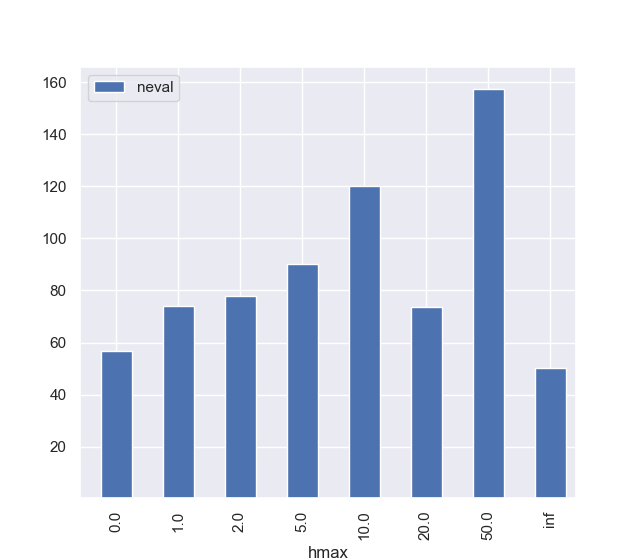

In [34]:
ax = feo_by_hmax.plot(kind='bar')

In [35]:
# performance criteria
def rel(x):
    return len([n for n in x if n < n p.inf])/len(x)
def mne(x):
    return np.mean([n for n in x if n < np.inf])
def feo(x):
    return mne(x)/rel(x)

In [36]:
results_pivot = def_table.pivot_table(
    index=['heur', 'hmax'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
results_pivot = results_pivot.reset_index()
results_pivot.sort_values(by='hmax')

heur  hmax         feo        mne       rel
0    SG_0   0.0   56.666667  17.000000  0.300000
1    SG_1   1.0   74.166667  14.833333  0.200000
3    SG_2   2.0   77.755102  18.142857  0.233333
5    SG_5   5.0   90.000000  15.000000  0.166667
2   SG_10  10.0  120.000000  12.000000  0.100000
4   SG_20  20.0   73.593750  19.625000  0.266667
6   SG_50  50.0  157.500000  10.500000  0.066667
7  SG_inf   inf   50.204082  11.714286  0.233333

In [39]:
results_pivot.sort_values(by=['feo']).head(1)

heur  hmax        feo        mne       rel
7  SG_inf   inf  50.204082  11.714286  0.233333

### Neighbourhood diameter

### Random Descent

In [40]:
def experiment_rd(of, num_runs, hmax, params):
    results = []
    for i in tqdm(range(num_runs), 'Testing hmax = {}'.format(hmax)):
        result = ShootAndGo(of, maxeval=maxeval, hmax=hmax, params=params,
                            random_descent=True).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'SG_RD_{}'.format(hmax) # name of the heuristic
        result['method'] = 'RD'
        result['hmax'] = hmax
        results.append(result)
    
    # write results to csv file 
    now = datetime.now()
    current_time = now.strftime('%Y%m%d%H%M')
    res = pd.DataFrame(results, columns=['heur', 'run', 'hmax', 'best_x', 'best_y', 'neval'])
    res.to_csv('../results/' + current_time + '_one_eighth_SG_RD' + str(hmax) + '.csv')
    
    return res

In [ ]:
for hmax in [0, 5, 10, 20, 50, np.inf]: 
    res = experiment_rd(n2v, maxeval, hmax, default_params)
    def_table = pd.concat([def_table, res], axis=0)

In [ ]:
def_table

In [ ]:
def_table.fillna('SD')

In [ ]:
g = sns.FacetGrid(def_table, col='of', size=6)
ax = g.map(sns.boxplot, 'hmax', 'best_y', 'method').add_legend(title='method')

## Conclusion